## 新网页 A/B 测试结果


## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

使用概率分析、线性回归以及逻辑回归，分析新网页 A/B 测试结果

<a id='probability'></a>
#### I - 概率

让我们先导入库，然后开始你的任务吧。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# We are setting the seed to assure you get the same answers on quizzes as we set up
# 我们正在设定种子，以确保您在我们设置的测验中获得相同的答案
random.seed(42)

`1.` 现在，导入 `ab_data.csv` 数据，并将其存储在 `df` 中。  **使用你的 dataframe 来回答课堂测试 1 中的问题。**

a. 导入数据集，并在这里查看前几行：

In [2]:
df = pd.read_csv('./ab-data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 使用下面的单元格来查找数据集中的行数。

In [18]:
df.shape[0]

294478

c. 数据集中独立用户的数量。

In [19]:
df.user_id.nunique()

290584

d. 用户转化的比例。

In [20]:
df.converted.mean()

0.11965919355605512

e.  `new_page` 与 `treatment` 不一致的次数。

In [21]:
# 计算 treatment 不是匹配 new_page 的行
df[((df['group'] == 'treatment') == (
    df['landing_page'] == 'new_page')) == False].shape[0]

3893


f. 是否有任何行存在缺失值？

In [22]:
# 计算缺失值数量
df.isnull().sum().sum()

0

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。我们应该如何处理这些行？在课堂中的 **测试 2** 中，给出你的答案。  

a. 现在，使用测试题的答案创建一个符合测试规格要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [88]:
# 只使用数据准确的行，删除这些行，不使用混乱数据
df2 = df[((df['group'] == 'treatment') == (
    df['landing_page'] == 'new_page')) == True]

In [89]:
# Double Check all of the correct rows were removed - this should be 0
# Double检查所有正确的行都被删除了 - 这应该是0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [90]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

`3.` 使用 **df2** 与下面的单元格来回答课堂中的 **测试3** 。

a.  **df2** 中有多少唯一的 **user_id**?

In [91]:
df2.user_id.nunique()

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？ 

In [92]:
dup_num = list(df2[df2.user_id.duplicated()]['user_id'])
dup_num[0]

773192

c. 这个重复的  **user_id** 的行信息是什么？

In [93]:
df2[df2['user_id'] == dup_num[0]]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. 删除 **一个** 含有重复的 **user_id** 的行， 但需要确保你的 dataframe 为 **df2**。

In [94]:
# 删除重复行
df2 = df2.drop_duplicates(subset='user_id')

In [95]:
# 检查重复行是否删除成功
len(df2[df2.user_id.duplicated()]['user_id'])

0

`4.` 在下面的单元格中，使用 **df2** 来回答与课堂中的 **测试 4** 相关的测试题目。

a. 不管它们收到什么页面，单个用户的转化率是多少？


In [31]:
df2['converted'].mean()

0.11959749882133504

b. 假定一个用户处于 `control` 组中，他的转化率是多少？

In [32]:
control_ctr = df2.query('group == "control"')['converted'].mean()
control_ctr

0.1203863045004612

c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [33]:
treatment_ctr = df2.query('group == "treatment"')['converted'].mean()
treatment_ctr

0.11880888313869065

d. 一个用户收到新页面的概率是多少？


In [96]:
df2.query('landing_page == "new_page"').count()['user_id'] / df2.shape[0]

0.5000619442226688

e. 使用这个问题的前两部分的结果，给出你的建议：你是否认为有证据表明一个页面可以带来更多的转化？在下面写出你的答案。

**在这里写出你的答案。**

<font color = green>

结论：control 组旧页面转化率是 12.04% ， treatment 组新页面转化率是 11.88% ，两相比较旧页面转化率更大，以此认为新页面不能带来更多转化率，建议保留旧页面。

----

##### 另一种方法

* 这里用了另一种自助法求结果：

假設零假设和对立假设如下（转化率为 CTR）:

  $H_0: CTR_{new} - CTR_{old} \leq 0$
  
  $H_1: CTR_{new} - CTR_{old} > 0$

In [35]:
# 计算对照组和控制组点击率差值
obs_diff = treatment_ctr - control_ctr
obs_diff

-0.0015774213617705535

In [36]:
# 进行抽样分布
diffs = []
for i in range(10000):
    b_samp = df2.sample(df2.shape[0], replace=True)
    control_ctr = b_samp.query('group == "control"')['converted'].mean()
    treatment_ctr = b_samp.query('group == "treatment"')['converted'].mean()
    diffs.append(treatment_ctr - control_ctr)

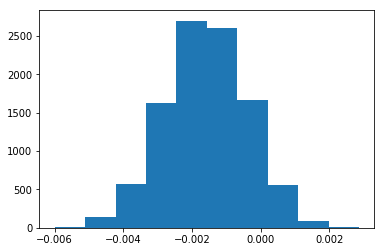

In [37]:
plt.hist(diffs);

In [38]:
# 在零假设下模拟分布
diffs = np.array(diffs)
null_vals = np.random.normal(0, diffs.std(), diffs.size)

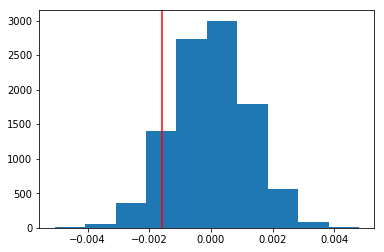

In [39]:
# 零假设分布
plt.hist(null_vals);
# 绘制观察到的具有零分布的统计量
plt.axvline(x=obs_diff, color='r');

In [40]:
# 得到的 P 值：
(null_vals > obs_diff).mean()

0.8984

<font color = green>


结论：控制组和试验组点击率的差异看起来非常显著（ $p$ 值太大），我们不拒绝零假设，并且根据这个结果可以认为新版本网页没有带来更多的转化

<a id='ab_test'></a>
### II - A/B 测试

请注意，由于与每个事件相关的时间戳，你可以在进行每次观察时连续运行假设检验。  

然而，问题的难点在于，一个页面被认为比另一页页面的效果好得多的时候你就要停止检验吗？还是需要在一定时间内持续发生？你需要将检验运行多长时间来决定哪个页面比另一个页面更好？

一般情况下，这些问题是A / B测试中最难的部分。如果你对下面提到的一些知识点比较生疏，请先回顾课程中的“描述统计学”部分的内容。

`1.` 现在，你要考虑的是，你需要根据提供的所有数据做出决定。如果你想假定旧的页面效果更好，除非新的页面在类型I错误率为5％的情况下才能证明效果更好，那么，你的零假设和备择假设是什么？ 你可以根据单词或旧页面与新页面的转化率 **$p_{old}$** 与 **$p_{new}$** 来陈述你的假设。

**在这里给出你的答案。**

<font color = green>

零假设和对立假设如下（网页转化率为 P）:

  $H_0: p_{new} - p_{old} \leq 0$
  
  $H_1: p_{new} - p_{old} > 0$

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>

使用下面的单元格提供这个模拟的必要内容。如果现在还没有完整的意义，不要担心，你将通过下面的问题来解决这个问题。你可以通过做课堂中的 **测试 5** 来确认你掌握了这部分内容。<br><br>

a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是多少？


In [99]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是多少？ <br><br>

In [100]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c.  $n_{new}$ 是多少？

In [101]:
n_new = df2.query('landing_page == "new_page"')['landing_page'].count()
n_new

145310

d.  $n_{old}$?是多少？

In [102]:
n_old = df2.query('landing_page == "old_page"')['landing_page'].count()
n_old

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。(提示：可以使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

> e. 在零假设中，使用 $p_{new}$ （新页面的转化率）模拟 $n_{new}$ 个新页面的转化，并将这些 $n_{new}$ 个 1 和 0 存储在 **new_page_converted** 中。(提示：可以使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

In [149]:
np.random.seed(42)
new_page_converted = np.random.choice(a=2, size=n_new, p=[1 - p_new, p_new])
new_page_converted

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

> f. 在零假设中，使用 $p_{old}$ （旧页面的转化率）模拟 $n_{old}$ 个旧页面的转化，并将这些  $n_{old}$ 个 1 和 0 存储在 **old_page_converted** 中。

In [151]:
np.random.seed(42)
old_page_converted = np.random.choice(a=2, size=n_old, p=[1 - p_old, p_old])
old_page_converted

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

> g. 根据 e 和 f，计算 $p_{new}$ 和 $p_{old}$ 的差异值（$p_{new}$ - $p_{old}$）。

In [152]:
new_page_converted.mean() - old_page_converted.mean()

3.258880437348455e-05

h. 使用**a. 到 g. ** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

> h. 由于单个数值不能形成分布图形，请参考以上a-g的过程，模拟 10,000 个 $p_{new}$ 与 $p_{old}$ 差异值（$p_{new}$ - $p_{old}$），将这 10,000 个值存储在 **p_diffs** 中。

In [154]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice(a=2, size=n_new, p=[1 - p_new, p_new])
    old_page_converted = np.random.choice(a=2, size=n_old, p=[1 - p_old, p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. 绘制一个 **p_diffs** 直方图。这个直方图看起来像你所期望的吗？通过回答课堂上的匹配问题，确保你完全理解这里计算出的内容。

> i. 绘制一个 **p_diffs** 分布图形。图形跟你的预期相符吗？

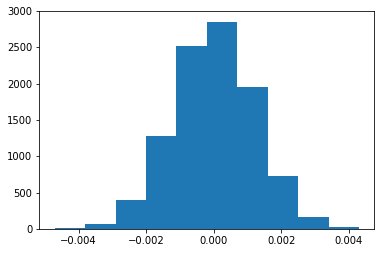

In [155]:
plt.hist(p_diffs);

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

> j.  **p_diffs**列表的数值中，有多少比例的数值会大于 **ab_data.csv** 中观察到的实际**转化率差异** ？

In [157]:
# 实际转化率
con_new = df2.query('group == "treatment"')['converted'].mean()
con_old = df2.query('group == "control"')['converted'].mean()
actual_diff = con_new - con_old
actual_diff

-0.0015782389853555567

In [158]:
# 得到的 P 值：
(p_diffs > actual_diff).mean()

0.9043

k. 用文字解释一下你刚才在 **j.**中计算出来的结果。在科学研究中，这个值是什么？ 根据这个数值，新旧页面的转化率是否有区别呢？

> k. 用文字解释一下你刚才在 **j.** 中计算出来的结果。在数据研究中，这个值是什么？ 根据这个数值，请判断新旧页面的转化率是否有显著差异。

**在这里给出你的答案。**


<font color = green>


  $H_0: p_{new} - p_{old} \leq 0$
  
  $H_1: p_{new} - p_{old} > 0$


* **j. 计算出来的结果，在数据研究中，0.9043 这个值是 p 值**

* **新旧网页转化率的差异看起来并不显著（ p 值太大），我们无法拒绝零假设**

---

l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。尽管使用内置程序可能更易于编写代码，但上面的内容是对正确思考统计显著性至关重要的思想的一个预排。填写下面的内容来计算每个页面的转化次数，以及每个页面的访问人数。使用 `n_old` 与 `n_new` 分别引证与旧页面和新页面关联的行数。

> l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。使用内置程序可能很容易就能取得结果，但上面的内容仍然很重要，它可以训练你具有正确的数据统计思维。填写下面的内容来计算每个页面的转化次数，以及收到每个页面的用户数。计算新旧页面出现的次数，也就是数据中 `n_old` 与 `n_new` 分别出现的行数。

In [162]:
df_old = df2.query('landing_page == "old_page"')
df_new = df2.query('landing_page == "new_page"')

In [163]:
import statsmodels.api as sm

convert_old = df_old['converted'].sum()
convert_new = df_new['converted'].sum()
n_old = df_old.shape[0]
n_new = df_new.shape[0]

m. 现在使用 `stats.proportions_ztest` 来计算你的检验统计量与 p-值。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 是使用内置程序的一个有用链接。

In [164]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old],
                                              [n_new, n_old],
                                              alternative='larger')
(z_score, p_value)

(-1.3109241984234394, 0.9050583127590245)

n. 根据上题算出的 z-score 和 p-value，我们认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 中的结果一致吗？

**在这里给出你的答案。**

<font color = green>

结论：p-value = 0.9051，和 j.与k.中结果一致。我们可以接受零假设，并且根据这个结果认为新网页转化率小于等于旧网页转化率，旧的页面效果更好。

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在最后一部分中，你会看到，你在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？

**在这里给出你的答案。**

<font color = green>

答：这次是预测两个可能结果的分类变量，使用逻辑回归。

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [177]:
df3 = df2.copy()

In [178]:
# 增加截距
df3['intercept'] = 1

In [179]:
# 创建 group 虚拟变量
df3[['control', 'ab_page']] = pd.get_dummies(df3['group'])
df3.drop('control', axis=1, inplace=True)

In [180]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0



c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [183]:
import statsmodels.api as sm

# 拟合了一个模型
log_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. 请在下方提供你的模型摘要，并根据需要使用它来回答下面的问题。

In [184]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 10 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        18:25:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br>  **提示**: 与你的回归模型相关的零假设与备择假设分别是什么？它们如何与 **Part II** 中的零假设和备择假设做比较？

**在这里给出你的答案。**

<font color = green>

ab_page关联的：$b_0=-1.9888 \\ b_1=-0.0150 \\ p=0.190$

<font color = green>

* PartⅡ的 p 值（0.9）是单尾检验，而 ab_page 是双尾检验，因此 p 值是会存在差异的。


* 这里的 $p_{ab_page} = 0.190 > 0.05$ ，无法拒绝零假设，以此结果得出结论新旧页面转化率没有显著区别，同时也表明 ab_page 这个因素不太适合用来预测转化率。


* 与回归模型相关的零假设与备择假设：
$$
H_0 : p_{new} = p_{old}  \\
H_1 : p_{new} \neq p_{old}  \\
一类错误率 : \alpha=0.05
$$




f. 现在，你一定在考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？

**在这里给出你的答案。**

<font color = green>

* 在实际应用时，有可能出现多种因素影响到反应变量，那么新增影响回归模型的变量，有助于避免辛普森悖论，也可以用另一种方式看待数据，有可能会发现其他不同的推论。


* 但是新增附加项越多，越容易影响回归系数，使结果与本来想要的方向偏移。

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。你需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？不要忘记为这些国家的列创建虚拟变量—— **提示: 你将需要为这三个虚拟变量增加两列。** 提供统计输出，并书面回答这个问题。

In [187]:
# 加入 country 列
df_countries = pd.read_csv('./countries.csv')
df_c = df_countries.set_index('user_id').join(df3.set_index('user_id'), how='inner')

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [190]:
df_c['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [193]:
# 创建 country 虚拟变量
df_c[['CA', 'UK', 'US']] = pd.get_dummies(df_c['country'])

In [202]:
df_c.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,US,UK
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0


In [206]:
# 输出报告
lm = sm.Logit(df_c['converted'], df_c[['intercept', 'CA', 'UK', 'ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 10 May 2019   Pseudo R-squ.:               2.323e-05
Time:                        19:56:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

<font color = green>

结论：
* 现在每个变量的 p 值都大于 $\alpha=0.05\$，对转化率的影响不具有统计学显著性，可以看出这个国家项对转化没有影响。


h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [207]:
df_c['new_CA'] = df_c['ab_page'] * df_c['CA']
df_c['new_UK'] = df_c['ab_page'] * df_c['UK']
df_c.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,US,UK,new_CA,new_UK
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,1


In [209]:
# 输出报告
lm = sm.Logit(df_c['converted'],
              df_c[['intercept', 'CA', 'UK', 'ab_page', 'new_CA', 'new_UK']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 10 May 2019   Pseudo R-squ.:               3.482e-05
Time:                        19:58:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
new_CA        -0.0469      0.054     -0.872      0.383      -0.152       0.059
new_UK         0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

<font color = green>

结论:
* 每个变量的 p 值仍然都大于 $\alpha=0.05\$，对转化率的影响不具有统计学显著性，就算增加查看页面与国家/地区之间的相互作用相关列，还是能得出国家项对转化没有影响的结论。

<a id='conclusions'></a>
## 总结


## 结论

回到最终问题：根据我们的 A/B 测试结果，**是否推荐这家电商发布新页面呢？**

<font color = green>

结论：

* 单纯只考虑从转化率角度分析数据，新旧页面并没有太大差异。后续引用的国家项也没能达到分析预期。


* 如果公司仍然想比较新旧页面，也许需要引用更多的变量或者延长测试时间，才能做出更准确的分析。